# Predicting daily energy consumption

## The data
Northern Illinois hourly power consumption data (2004-2010) acquired from [Kaggle](https://www.kaggle.com/robikscube/hourly-energy-consumption?select=NI_hourly.csv)  
Weather data (daily min and max temperatures) acquired from https://www.ncdc.noaa.gov/

## Preprocessing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [16,9]

In [2]:
mydateparser = lambda x: pd.datetime.strptime(x, "%Y-%m-%d %H:%M:%S")
consumption_data = pd.read_csv('./NI_hourly.csv', parse_dates=['Datetime'], date_parser=mydateparser)
consumption_data.columns = ['datetime', 'consumption']
consumption_data.shape

(58450, 2)

In [3]:
# adding the data column
consumption_data['date'] = consumption_data['datetime'].dt.date.astype('datetime64')
min(consumption_data.date),max(consumption_data.date)

(Timestamp('2004-05-01 00:00:00'), Timestamp('2011-01-01 00:00:00'))

In [4]:
# grouping the data by date to get the daily consumption
daily_consumption = consumption_data.groupby('date').sum()

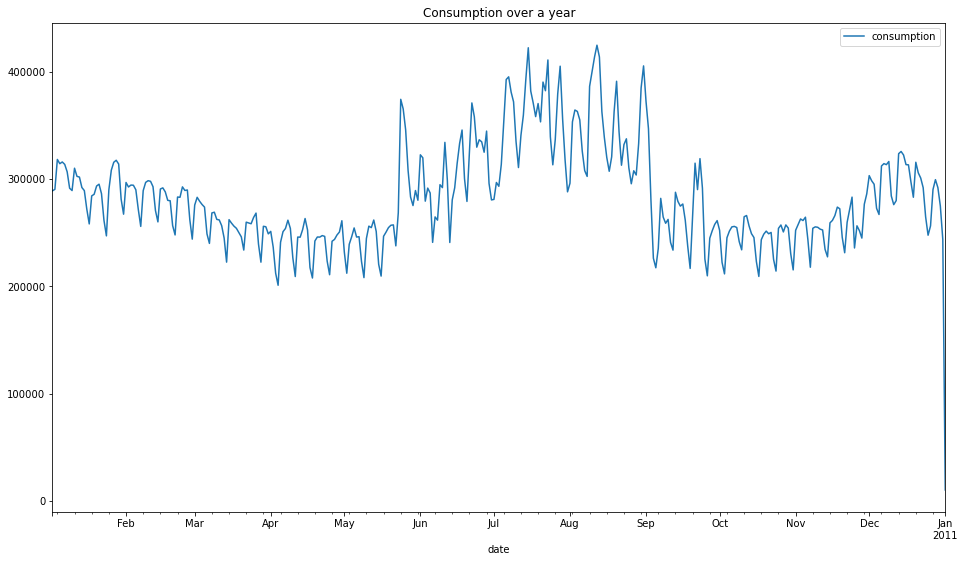

In [5]:
daily_consumption.tail(365).plot(title="Consumption over a year");

We can see a significant drop on the last day, looks like a partial reading that should be ignored

In [6]:
daily_consumption.tail()

,consumption
date,
2010-12-28,299529.0
2010-12-29,292097.0
2010-12-30,274924.0
2010-12-31,243774.0
2011-01-01,10042.0


In [7]:
# dropping outlier
daily_consumption.drop(pd.to_datetime('2011-01-01'), inplace=True)

In [8]:
daily_consumption.describe()

,consumption
count,2436.000000
mean,280769.017241
std,41773.959126
min,198158.000000
25%,253701.250000
50%,273573.500000
75%,302444.750000
max,481122.000000


### Adding weather data

In [9]:
weather = pd.read_csv('./NI_weather.csv', parse_dates=['DATE'])
# getting the average readings per day from all weather stations
weather_agg = weather.groupby('DATE').mean()
weather_agg.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2555 entries, 2004-01-01 to 2010-12-31
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   TMAX    2552 non-null   float64
 1   TMIN    2552 non-null   float64
dtypes: float64(2)
memory usage: 59.9 KB


In [10]:
 # fill data for missing days with readings from previous day 
 weather_agg.fillna(method='ffill', inplace=True)

In [11]:
# merging the consumption data with the min and max daily temperatures
dataset = daily_consumption.merge(weather_agg, right_index=True, left_index=True, how='inner')[['TMIN','TMAX','consumption']]
dataset.columns = ['temp_min', 'temp_max', 'consumption']
dataset.sample(10)

,temp_min,temp_max,consumption
2006-05-20,36.0,73.0,226752.0
2009-10-18,25.0,54.0,221450.0
2008-11-07,34.0,46.0,262309.0
2005-11-08,47.0,64.0,259652.0
2008-09-21,52.0,82.0,252710.0
2009-01-15,-24.0,-10.0,344545.0
2007-01-03,31.0,47.0,281245.0
2009-04-27,56.0,70.0,253966.0
2006-08-21,51.0,80.0,308652.0
2006-07-17,72.0,95.0,448629.0


In [12]:
#!pip install holidays
import holidays
us_holidays = holidays.UnitedStates()

In [13]:
# adding business day indication based on weekdays and US holidays
dataset['business_day'] = dataset.index.to_series().dt.date.apply(lambda x: np.is_busday(x) and x not in us_holidays)
dataset['day_of_week'] = dataset.index.to_series().dt.dayofweek

In [14]:
dataset.corr()

,temp_min,temp_max,consumption,business_day,day_of_week
temp_min,1.000000,0.922018,0.250236,0.032221,-0.028940
temp_max,0.922018,1.000000,0.203218,0.021302,-0.015841
consumption,0.250236,0.203218,1.000000,0.409235,-0.326363
business_day,0.032221,0.021302,0.409235,1.000000,-0.715377
day_of_week,-0.028940,-0.015841,-0.326363,-0.715377,1.000000


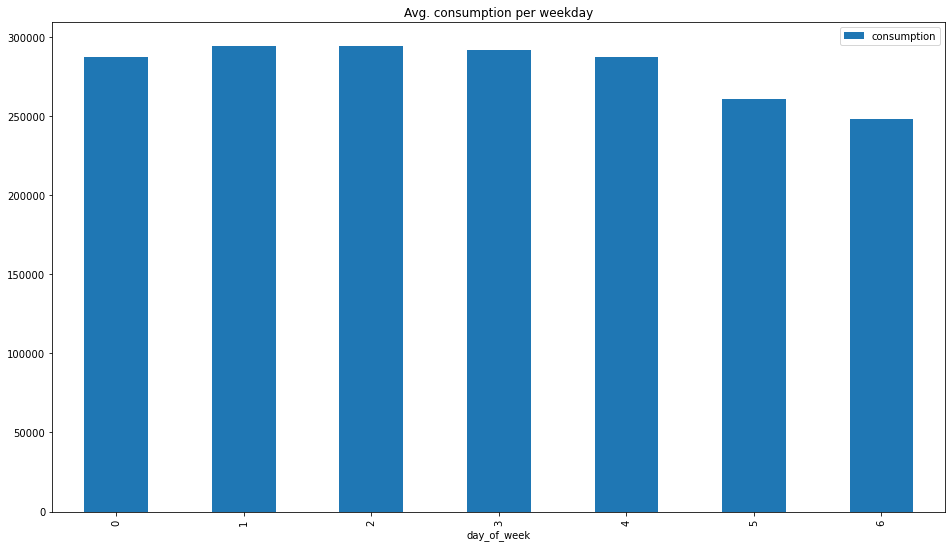

In [15]:
dataset[['day_of_week','consumption']].groupby('day_of_week').mean().plot(kind="bar", title="Avg. consumption per weekday");

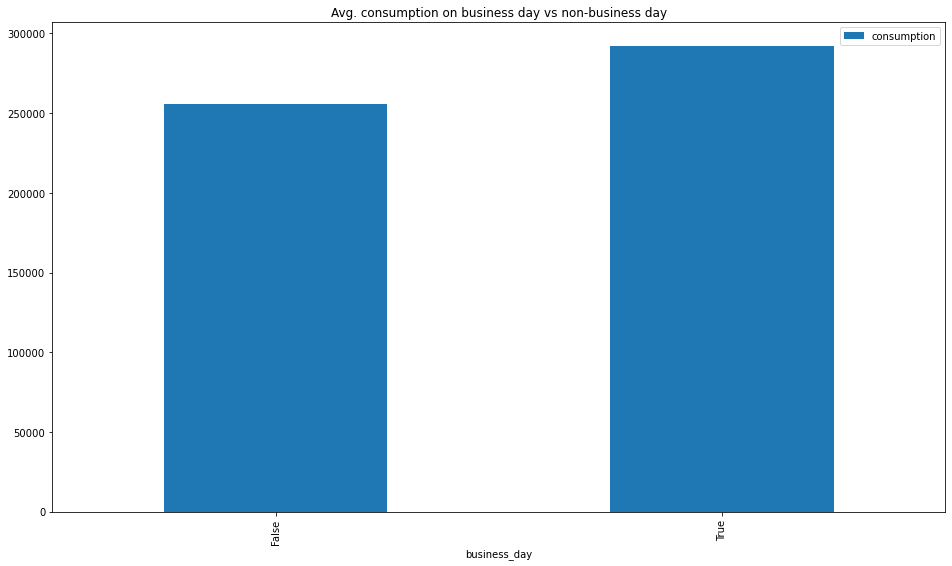

In [16]:
dataset[['business_day','consumption']].groupby('business_day').mean().plot(kind="bar", title="Avg. consumption on business day vs non-business day");

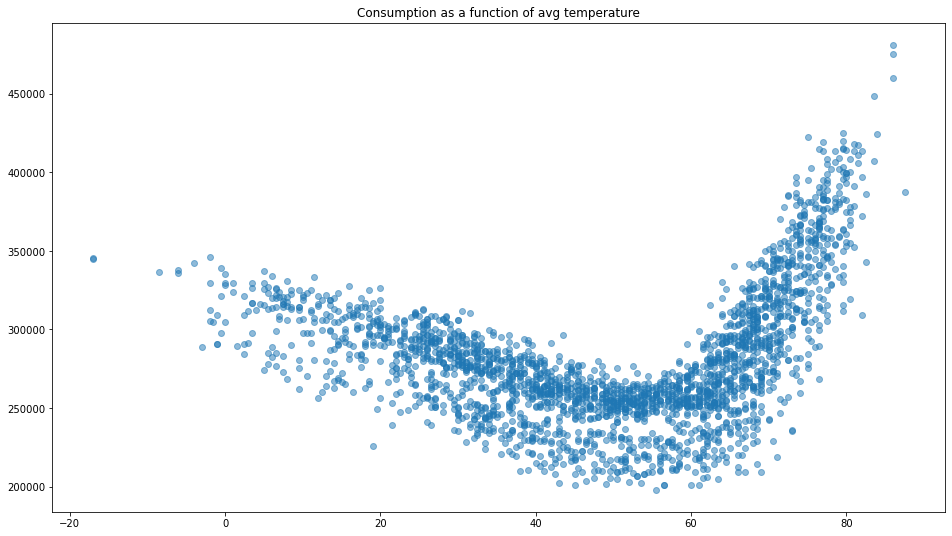

In [17]:
plt.scatter(x=(dataset.temp_max + dataset.temp_min)/2, y=dataset.consumption, alpha=0.5)
plt.title('Consumption as a function of avg temperature');

We can see that the consumption is higher when it's colder but much higher when it's warmer. I assume this is because cooling is based more on electricity and heating uses more natural gas.

## Learning
I'll be using the temperature features as numerical features and apply scaling and polynomial transformations.  
For the categorical features of business day and day of the week I'll apply the one-hot encoding transformation.

In [18]:
from sklearn.model_selection import train_test_split, cross_val_score

numeric_features = ['temp_min','temp_max']
categorical_features = ['business_day','day_of_week']

X = dataset[numeric_features + categorical_features]
y = dataset.consumption
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [19]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline

numeric_transformer = Pipeline(steps=[('poly',PolynomialFeatures()),
                                      ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])


In [20]:
from sklearn.linear_model import LinearRegression
lr = Pipeline([('preprocessor', preprocessor), ('model', LinearRegression())])
lr.fit(X_train, y_train)
scores = cross_val_score(lr, X, y, cv=5, scoring='neg_mean_squared_error')
print("RMSE: {}".format(np.mean(np.sqrt(-scores)))) 

RMSE: 22712.287362345796


## Trying Ridge regression with parameter tuning

In [21]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
param_grid = {
    'preprocessor__num__poly__degree': range(2,10),
    'model__alpha': np.logspace(-6, 1, num=6)}

ridge = Pipeline([('preprocessor', preprocessor), ('model', Ridge())])
gs_ridge = GridSearchCV(ridge, param_grid=param_grid)
gs_ridge.fit(X_train, y_train)
scores = cross_val_score(gs_ridge, X, y, cv=5, scoring='neg_mean_squared_error')
print("RMSE: {}".format(np.mean(np.sqrt(-scores))))

RMSE: 16218.733315703092


In [22]:
gs_ridge.best_params_

{'model__alpha': 0.3981071705534969, 'preprocessor__num__poly__degree': 9}

## Adding the temperatures of the prior day

In [23]:
import datetime
weather_agg['tomorrow'] = weather_agg.index.to_series().apply(lambda x: x + datetime.timedelta(days=1))
dataset_w_yesterday = dataset.merge(weather_agg, right_on='tomorrow', left_index=True, how='inner')
dataset_w_yesterday.rename(columns = {'TMAX': 'temp_max_yesterday', 'TMIN': 'temp_min_yesterday'}, inplace=True)

In [24]:
numeric_features = ['temp_min','temp_max','temp_max_yesterday','temp_min_yesterday']
X = dataset_w_yesterday[numeric_features + categorical_features]
y = dataset_w_yesterday.consumption
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [25]:
gs_ridge2 = GridSearchCV(ridge, param_grid=param_grid)
gs_ridge2.fit(X_train, y_train)
scores = cross_val_score(gs_ridge2, X, y, cv=5, scoring='neg_mean_squared_error')
print("RMSE: {}".format(np.mean(np.sqrt(-scores))))

RMSE: 16202.923346350513


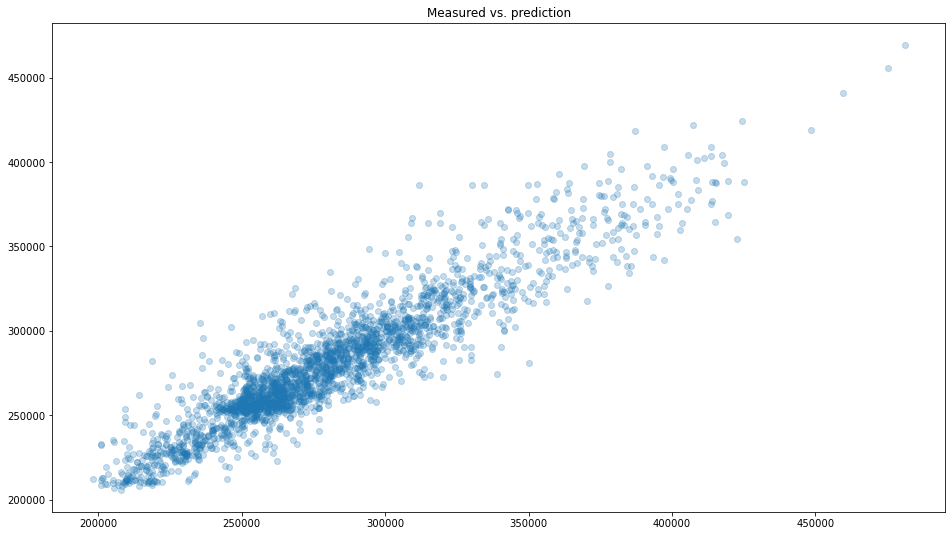

In [26]:
plt.scatter(y, gs_ridge2.predict(X), alpha=0.25)
plt.title("Measured vs. prediction");